In [3]:
import json
from typing import List

import numpy as np
import numpy.typing as npt
import seaborn
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

import spectrum_painting_data as sp_data
import spectrum_painting_training as sp_training
from training.result import Result
from training.spectrum_painting import augment_spectrogram, downsample_spectrogram, paint_spectrogram


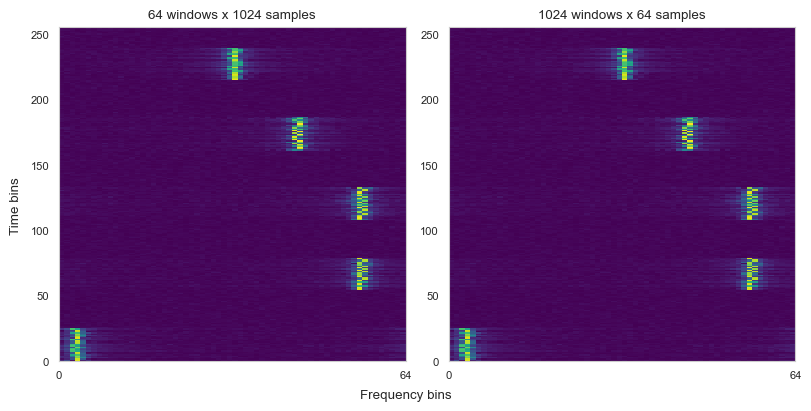

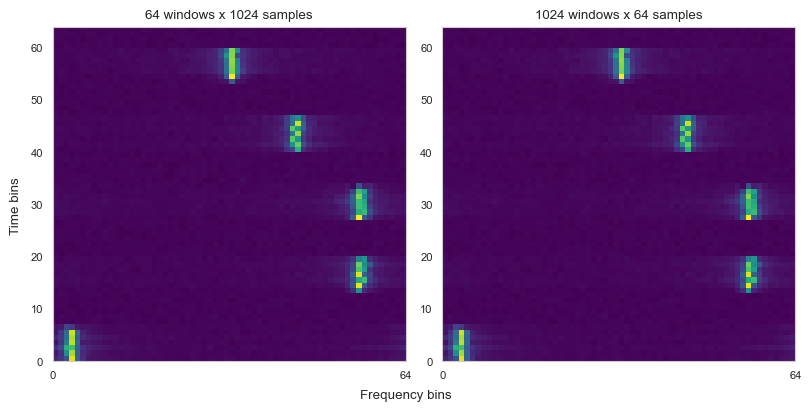

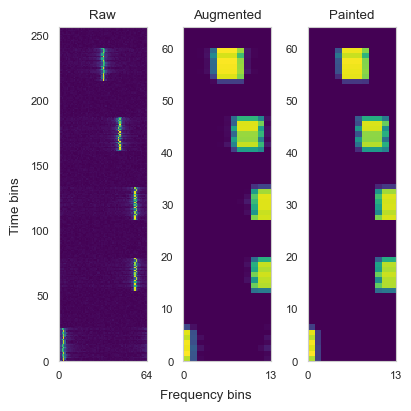

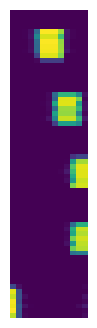

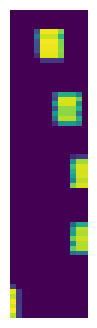

In [8]:
classes = ["ZBW"]
snr = 15

spectrum_painting_options = sp_training.SpectrumPaintingTrainingOptions(
    downsample_resolution=64,
    k=3,
    l=16,
    d=4
)

high_freq_resolution_spec = sp_data.load_spectrograms(data_dir="data/numpy",
                                                      classes=classes,
                                                      snr_list=[snr],
                                                      windows_per_spectrogram=256,
                                                      window_length=256,
                                                      nfft=64).get(snr)[0].values

high_time_resolution_spec = sp_data.load_spectrograms(data_dir="data/numpy",
                                                      classes=classes,
                                                      snr_list=[snr],
                                                      windows_per_spectrogram=256,
                                                      window_length=256,
                                                      nfft=64).get(snr)[0].values

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), constrained_layout=True)


def plot_spectrogram(spectrogram: npt.NDArray, index: int, name: str):
    plt.subplot(1, 2, index)
    plt.pcolormesh(spectrogram, cmap='viridis')
    plt.title(name)
    plt.xticks((0, spectrogram.shape[1]))
    plt.xticks()


plot_spectrogram(high_freq_resolution_spec, 1, "64 windows x 1024 samples")
plot_spectrogram(high_time_resolution_spec, 2, "1024 windows x 64 samples")

fig.supxlabel("Frequency bins")
fig.supylabel("Time bins")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), constrained_layout=True)

plot_spectrogram(downsample_spectrogram(high_freq_resolution_spec, 64), 1, "64 windows x 1024 samples")
plot_spectrogram(downsample_spectrogram(high_time_resolution_spec, 64), 2, "1024 windows x 64 samples")

fig.supxlabel("Frequency bins")
fig.supylabel("Time bins")
plt.show()

spec = sp_data.load_spectrograms(data_dir="data/numpy",
                                 classes=classes,
                                 snr_list=[snr],
                                 windows_per_spectrogram=256,
                                 window_length=256,
                                 nfft=64).get(snr)[0].values

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(4, 4), constrained_layout=True)


def plot_spectrogram(spectrogram: npt.NDArray, index: int, name: str):
    plt.subplot(1, 3, index)
    plt.pcolormesh(spectrogram, cmap='viridis')
    plt.title(name)
    plt.xticks((0, spectrogram.shape[1]))
    plt.xticks()


plot_spectrogram(spec.clip(max=0.04), index=1, name="Raw")

downsampled = downsample_spectrogram(spectrogram=spec, resolution=64)

augmented = augment_spectrogram(spectrogram=downsampled, k=3, l=16, d=4)
plot_spectrogram(augmented, index=2, name="Augmented")

painted = paint_spectrogram(downsampled, augmented)
plot_spectrogram(painted, index=3, name="Painted")

# fig.tight_layout()
fig.supxlabel("Frequency bins")
fig.supylabel("Time bins")
plt.show()

plt.figure(figsize=(1, 4))
plt.pcolormesh(augmented, cmap='viridis')
plt.axis("off")
plt.yticks(None)
plt.show()

plt.figure(figsize=(1, 4))
plt.pcolormesh(painted, cmap='viridis')
plt.axis("off")
plt.yticks(None)
plt.show()

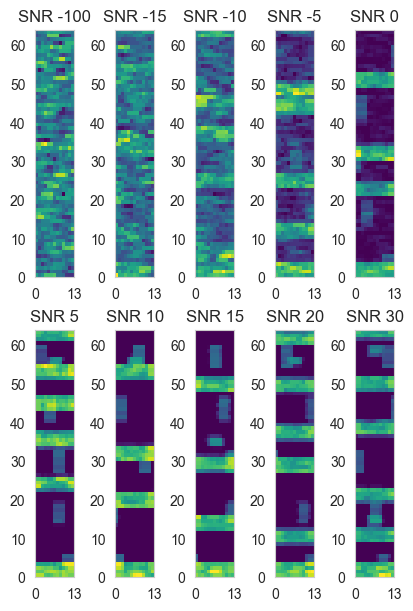

In [5]:
snr_list = [-100, -15, -10, -5, 0, 5, 10, 15, 20, 30]

spectrogram = sp_data.load_spectrograms(data_dir="data/numpy",
                                        classes=["ZBW"],
                                        snr_list=snr_list,
                                        windows_per_spectrogram=256,
                                        window_length=256,
                                        nfft=64)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(4, 6), constrained_layout=True)


def plot_spectrogram(spectrogram: npt.NDArray, index: int, name: str):
    plt.subplot(2, 5, index)
    plt.pcolormesh(spectrogram, cmap='viridis')
    plt.title(name)
    plt.xticks((0, spectrogram.shape[1]))
    plt.xticks()


for i, snr in enumerate(snr_list):
    spec = spectrogram[snr][0].values

    downsampled = downsample_spectrogram(spectrogram=spec, resolution=64)
    augmented = augment_spectrogram(spectrogram=downsampled, k=3, l=16, d=4)

    plot_spectrogram(augmented, i + 1, f"SNR {snr}")

# Read the results and create plots from notebook_spectrum_painting

In [6]:
file_name = "results-1-iteration-new.json"
results: List[Result]

with open(f"output/{file_name}", "r") as f:
    results = json.load(f)["results"]
    results = [Result.from_dict(r) for r in results]

Full model


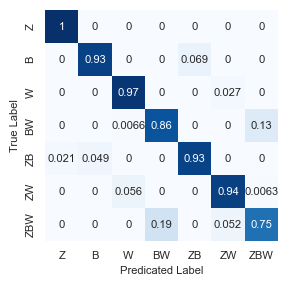

Lite model


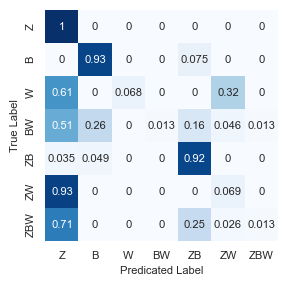

Lite model (no quantization)


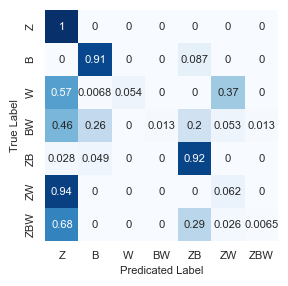

SNR -100
Accuracy = 0.14947965941343425


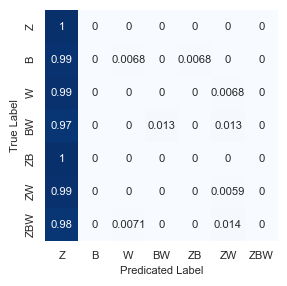

SNR -15
Accuracy = 0.3122043519394513


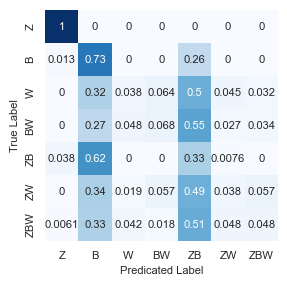

SNR -10
Accuracy = 0.5714285714285714


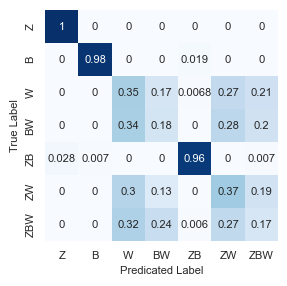

SNR -5
Accuracy = 0.6433301797540208


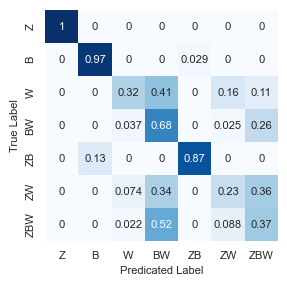

SNR 0
Accuracy = 0.8334910122989593


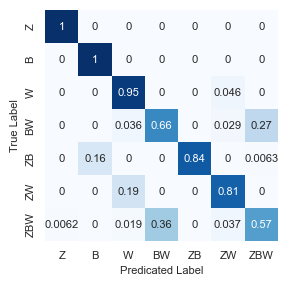

SNR 5
Accuracy = 0.9205298013245033


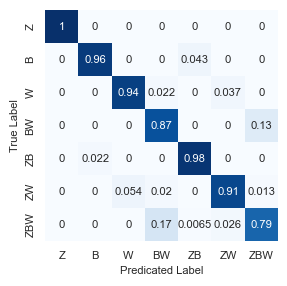

SNR 10
Accuracy = 0.9214758751182592


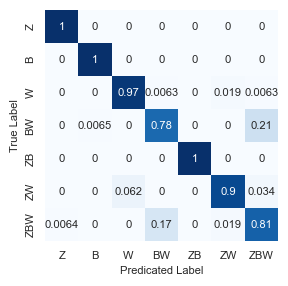

SNR 15
Accuracy = 0.4210028382213813


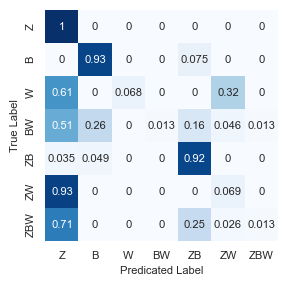

SNR 20
Accuracy = 0.9101229895931883


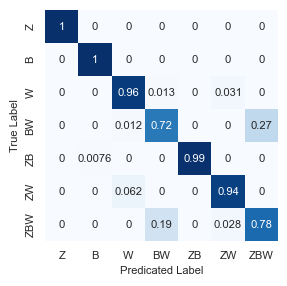

SNR 30
Accuracy = 0.9413434247871334


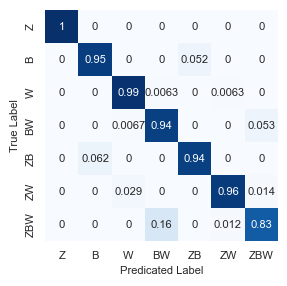

In [7]:
confusion_matrix_snr = 15
confusion_matrix_result: Result = list(filter(lambda r: r.snr == confusion_matrix_snr, results))[0]


def plot_confusion_matrix(y_predictions,
                          y_test,
                          label_names: List[str]):
    cm = confusion_matrix(y_test, y_predictions)
    cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])

    plt.figure(figsize=(3, 3))
    plt.rcParams.update({'font.size': 8})
    plot = seaborn.heatmap(cm, xticklabels=label_names, yticklabels=label_names, annot=True, cmap='Blues',cbar=False )
    plot.get_figure()
    plt.ylabel('True Label')
    plt.xlabel('Predicated Label')
    plt.show()


def concat(lists: List) -> List:
    output = []

    for l in lists:
        output.extend(l)

    return output


print("Full model")
plot_confusion_matrix(concat(confusion_matrix_result.full_model_predictions),
                      concat(confusion_matrix_result.full_model_labels),
                      confusion_matrix_result.label_names)

print("Lite model")
plot_confusion_matrix(concat(confusion_matrix_result.lite_model_predictions),
                      concat(confusion_matrix_result.lite_model_labels),
                      confusion_matrix_result.label_names)

print("Lite model (no quantization)")
plot_confusion_matrix(concat(confusion_matrix_result.lite_model_no_quant_predictions),
                      concat(confusion_matrix_result.lite_model_no_quant_labels),
                      confusion_matrix_result.label_names)

for (i, result) in enumerate(results):
    snr = result.snr
    print(f"SNR {snr}")
    
    y_test = concat(result.lite_model_labels)
    predictions = concat(result.lite_model_predictions)
    
    avg_accuracy = np.mean(np.array(y_test) == np.array(predictions))
    print(f"Accuracy = {avg_accuracy}")

    plot_confusion_matrix(predictions, y_test, result.label_names)